# Objectives and Data wrangling

## Table of Contents
  * 1. [Objectives](#Objectives)
  * 2. [Imports](#Imports)
  * 3. [Load data](#Load_data)
  * 4. [Explore data](#Explore_data)
     * 4.1. [Event data including customer activities; 'view', 'add-to-cart' and 'transaction'](#Event_data)
     * 4.2. [Item properties data for 'item ID - category ID matching'](#Item_properties_data)  
     * 4.3. [Data containing hierarchical categories of items](#Category_data)
  * 5. [Save data](#Save_data)

## 1. Objectives<a id='Objectives'></a>
The NLP-based recommender systems studied in this work include an item-based collaborative filtering technique called **item2vec**, as well as a hybrid approach known as **higherarchical item2vec**, which incorporates hierarchical content-based information. The dataset used for evaluation is the [RetailRocket Recommender System Dataset]((https://www.kaggle.com/datasets/retailrocket/ecommerce-dataset)), obtained from Kaggle. The four files provided in the dataset will be used to test and evaluate our models.

- events.csv
- category_tree.csv
- item_properties_part1.csv
- item_properties_part2.csv

The dataset must include the following information: **transaction ID**, **item ID**, and **category information for each item**, as well as transaction date and time, and customer ID. For the initial study, the context window will be limited to a single transaction for simplicity. In later stages, model performance will be evaluated using varying context windows and/or including non-transactional activities. This will involve generalizing individual _**transactions**_ into broader _**sessions**_; sessions group customer activities based on temporal proximity, typically within a single day or across a week. 

## 2. Imports<a id='Imports'></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import datetime as dt
from sb_utils import save_file
pd.options.mode.copy_on_write = True

## 3. Load data<a id='Load_data'></a>

In [2]:
event_data = 'events.csv'
category_data = 'category_tree.csv'
item1_data = 'item_properties_part1.csv'
item2_data = 'item_properties_part2.csv'
df_evt = pd.read_csv(event_data)
df_cat = pd.read_csv(category_data)
df_item = pd.read_csv(item1_data) 
df_item2 = pd.read_csv(item2_data)

In [3]:
df_evt.head()

,timestamp,visitorid,event,itemid,transactionid
0,1433221332117,257597,view,355908,NaN
1,1433224214164,992329,view,248676,NaN
2,1433221999827,111016,view,318965,NaN
3,1433221955914,483717,view,253185,NaN
4,1433221337106,951259,view,367447,NaN


In [4]:
df_cat.head()

,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


In [5]:
df_item.head()

,timestamp,itemid,property,value
0,1435460400000,460429,categoryid,1338
1,1441508400000,206783,888,1116713 960601 n277.200
2,1439089200000,395014,400,n552.000 639502 n720.000 424566
3,1431226800000,59481,790,n15360.000
4,1431831600000,156781,917,828513


## 4. Explore data<a id='Explore_data'></a>

### 4.1  Event data including customer activities; view, add-to-cart and transaction<a id='Event_data'></a>

In [6]:
df_evt = df_evt.drop_duplicates()

In [7]:
print(' [ Customer activities in raw numbers ]')
print(df_evt.event.value_counts())
print('\n [ Customer activities expressed in percentages ]')
print(round(df_evt.event.value_counts()/len(df_evt.event) * 100,2))

 [ Customer activities in raw numbers ]
event
view           2664218
addtocart        68966
transaction      22457
Name: count, dtype: int64

 [ Customer activities expressed in percentages ]
event
view           96.68
addtocart       2.50
transaction     0.81
Name: count, dtype: float64


In [8]:
print(' [ An example sequence of activities by a customer ]')
df_evt.loc[df_evt.visitorid == 90352]

 [ An example sequence of activities by a customer ]


,timestamp,visitorid,event,itemid,transactionid
265573,1434403666570,90352,view,425758,NaN
271793,1434404197081,90352,transaction,425758,0.0
277295,1434403991902,90352,addtocart,425758,NaN
533488,1435331816929,90352,view,425758,NaN


In [9]:
print(f'There are {df_evt.timestamp.nunique()} activity records by {df_evt.visitorid.nunique()} customers for {df_evt.itemid.nunique()} items in the data.')

There are 2750455 activity records by 1407580 customers for 235061 items in the data.


#### Convert timestamp to Datetime object

In [10]:
df_evt.timestamp =  pd.to_datetime(df_evt.timestamp, unit='ms')
df_evt['date'] = pd.to_datetime(df_evt.timestamp, unit='ms').dt.date
print(f' Data are from {df_evt.date.min()} to {df_evt.date.max()}.')

 Data are from 2015-05-03 to 2015-09-18.


#### Add a 'session' column
A session includes all activities performed by a customer on the same day.

In [11]:
# Create a helper DataFrame with unique (visitorid, date) and assign session numbers
unique_dates = df_evt[['visitorid', 'date']].drop_duplicates()
unique_dates['session_by_day'] = unique_dates.groupby('visitorid').cumcount() + 1 # start from session 1

# Merge back to the original dataframe
df_evt = df_evt.merge(unique_dates, on=['visitorid', 'date'], how='left')
df_evt = df_evt.loc[:, ~df_evt.columns.str.endswith('_x')]
df_evt = df_evt.loc[:, ~df_evt.columns.str.endswith('_y')]

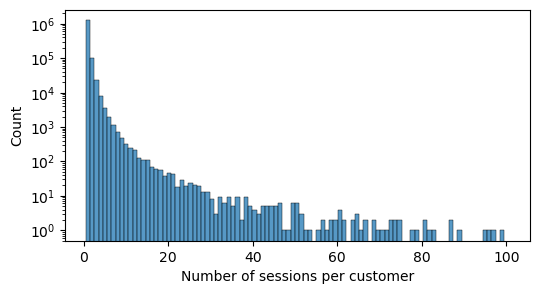

In [12]:
# plot distribution 
plt.subplots(figsize=(6,3))
num_sessions= df_evt.groupby('visitorid').agg(num_session=pd.NamedAgg(column='session_by_day', aggfunc='max'))
num_sessions=pd.DataFrame(num_sessions)
#num_sessions
bins = np.linspace(0.5, 100.5, 100)
sns.histplot(x='num_session',data=num_sessions, bins=bins)
plt.xlabel('Number of sessions per customer')
plt.yscale('log')

#### Impute missing values

In [13]:
df_evt.isnull().sum()

timestamp               0
visitorid               0
event                   0
itemid                  0
transactionid     2733184
date                    0
session_by_day          0
dtype: int64

In [14]:
df_evt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755641 entries, 0 to 2755640
Data columns (total 7 columns):
 #   Column          Dtype         
---  ------          -----         
 0   timestamp       datetime64[ns]
 1   visitorid       int64         
 2   event           object        
 3   itemid          int64         
 4   transactionid   float64       
 5   date            object        
 6   session_by_day  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 147.2+ MB


In [15]:
df_evt.groupby('event')['transactionid'].apply(lambda x: x.count())

event
addtocart          0
transaction    22457
view               0
Name: transactionid, dtype: int64

In [16]:
df_evt.transactionid= df_evt.transactionid.fillna(-1).astype('int64')
df_evt.dtypes

timestamp         datetime64[ns]
visitorid                  int64
event                     object
itemid                     int64
transactionid              int64
date                      object
session_by_day             int64
dtype: object

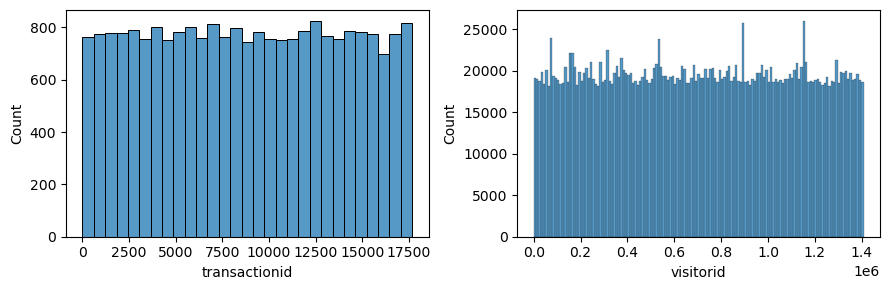

In [17]:
# Plot histograms for transaction ID (for 'transaction' events only), and customer ID.
fig,ax = plt.subplots(1,2, figsize=[9,3])
sns.histplot(x='transactionid',data=df_evt[df_evt.event=='transaction'],ax=ax[0])
sns.histplot(x='visitorid',data=df_evt,ax=ax[1])
plt.tight_layout()
plt.show()

In [18]:
df_evt.sort_values('visitorid', inplace=True)
df_evt.head()

,timestamp,visitorid,event,itemid,transactionid,date,session_by_day
1361452,2015-09-11 20:49:49.439,0,view,285930,-1,2015-09-11,1
1366977,2015-09-11 20:52:39.591,0,view,357564,-1,2015-09-11,1
1367107,2015-09-11 20:55:17.175,0,view,67045,-1,2015-09-11,1
830254,2015-08-13 17:46:06.444,1,view,72028,-1,2015-08-13,1
726186,2015-08-07 18:01:08.920,2,view,216305,-1,2015-08-07,1


In [19]:
print(f"There are {df_evt.loc[df_evt.event == 'transaction'].transactionid.nunique()} transactions by {df_evt.loc[df_evt.event == 'transaction'].visitorid.nunique()} customers for {df_evt.loc[df_evt.event == 'transaction'].itemid.nunique()} items in the data.")

There are 17672 transactions by 11719 customers for 12025 items in the data.




### 4.2. Item properties data<a id='Item_properties_data'></a>

#### Concatenate two item properties files

In [20]:
df_item = pd.concat([df_item, df_item2], axis=0)
df_item.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   timestamp  int64 
 1   itemid     int64 
 2   property   object
 3   value      object
dtypes: int64(2), object(2)
memory usage: 773.5+ MB


In [21]:
df_item.timestamp =  pd.to_datetime(df_item.timestamp, unit='ms')
df_item['date'] = pd.to_datetime(df_item.timestamp, unit='ms').dt.date
print(f' Data are from {df_item.date.min()} to {df_item.date.max()}.')

 Data are from 2015-05-10 to 2015-09-13.


In [22]:
nitems = df_item.loc[(df_item.property == "categoryid")].itemid.nunique()
ncat = df_item.loc[(df_item.property == "categoryid")].value.nunique()
print(f'There are {nitems} unique items with an associated category ID, and a total of {ncat} unique category IDs in the item properties data.')

There are 417053 unique items with an associated category ID, and a total of 1242 unique category IDs in the item properties data.


#### Add 'category ID' to event data

In [23]:
# Extract rows containing category ID
item_cat = df_item.loc[df_item.property == "categoryid",['itemid','value','date']]
item_cat = item_cat.drop_duplicates(subset=['itemid','value'], keep='first')
item_cat.rename(columns={'value': 'categoryid'}, inplace=True)

In [24]:
# Check if each item has unique category ID
numcat= item_cat.groupby(['itemid']).agg({'categoryid':'count'})
numcat.reset_index(inplace=True)
print(f'Approximately {100*numcat[numcat.categoryid>1].itemid.count()/numcat.itemid.count():.1f}% of items are linked to more than one category ID.')

Approximately 5.6% of items are linked to more than one category ID.


Text(0.5, 0, 'number of category IDs per item')

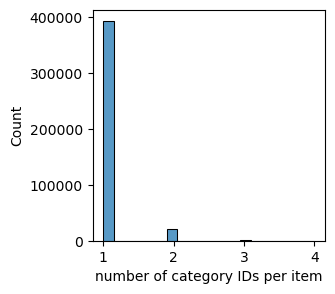

In [25]:
# Plot the number of category IDs per item
plt.figure(figsize=(3,3))
sns.histplot(x='categoryid',data=numcat)
plt.xlabel('number of category IDs per item')

In [26]:
numcat[numcat.categoryid>1].head()

,itemid,categoryid
24,25,2
88,94,2
121,130,2
139,149,2
158,168,2


In [27]:
# Let's take a look into item 25
item_cat[item_cat.itemid==25]

,itemid,categoryid,date
7786530,25,1509,2015-05-10
10171938,25,72,2015-09-13


In [28]:
df_item[(df_item.itemid==25) & (df_item.property=='categoryid')].sort_values('timestamp')

,timestamp,itemid,property,value,date
7786530,2015-05-10 03:00:00,25,categoryid,1509,2015-05-10
8382882,2015-05-17 03:00:00,25,categoryid,1509,2015-05-17
8581666,2015-05-24 03:00:00,25,categoryid,1509,2015-05-24
8979234,2015-05-31 03:00:00,25,categoryid,1509,2015-05-31
7985314,2015-06-07 03:00:00,25,categoryid,1509,2015-06-07
8184098,2015-06-14 03:00:00,25,categoryid,1509,2015-06-14
8780450,2015-06-28 03:00:00,25,categoryid,1509,2015-06-28
9575586,2015-07-05 03:00:00,25,categoryid,1509,2015-07-05
9376802,2015-07-12 03:00:00,25,categoryid,1509,2015-07-12
9178018,2015-07-19 03:00:00,25,categoryid,1509,2015-07-19


It appears that the assignment of category IDs to items changes occasionally. We can either assign the first observed category ID to these items or exclude them entirely, as they account for only 5.6% of the total.

In [29]:
item_cat.sort_values(by='date',inplace=True)
item_cat = item_cat.drop_duplicates(subset='itemid', keep='first')

# Check again all items have a unique category ID
numcat= item_cat.groupby(['itemid']).agg({'categoryid':'count'})
numcat[numcat.categoryid>1].sum()

categoryid    0
dtype: int64

In [30]:
# Incorporate category ID to event data
df_evt = df_evt.merge(item_cat, on=['itemid'], how='left')

In [31]:
nocat = df_evt[df_evt.categoryid.isnull()].itemid.nunique()
totitems = df_evt.itemid.nunique()
print(f'Only {nocat}/{totitems} * 100 = {100*nocat/totitems:.2f} % of unique items found in the event data have no associated category ID.')

Only 49815/235061 * 100 = 21.19 % of unique items found in the event data have no associated category ID.


In [32]:
nocat_trs = df_evt.loc[df_evt.categoryid.isnull() & (df_evt.event=='transaction')].itemid.nunique()
totitems_trs = totitems = df_evt[df_evt.event=='transaction'].itemid.nunique()
print(f'Only {nocat_trs}/{totitems_trs} * 100 = {100*nocat_trs/totitems_trs:.2f} % of unique items found in transactions have no associated category ID.')

Only 380/12025 * 100 = 3.16 % of unique items found in transactions have no associated category ID.


#### Impute missing values

In [33]:
df_evt.categoryid= df_evt.categoryid.fillna(-1).astype('int64')
df_evt.isnull().sum()

timestamp              0
visitorid              0
event                  0
itemid                 0
transactionid          0
date_x                 0
session_by_day         0
categoryid             0
date_y            255576
dtype: int64

### 4.3. Data containing hierarchical categories of items<a id='Category_data'></a>

In [34]:
df_cat = df_cat.drop_duplicates()
df_cat.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [35]:
print(df_cat.categoryid.nunique())

1669


All category IDs are unique.

#### Assign appropriate parent ID to root node

In [36]:
df_cat[df_cat.parentid == 0]

,categoryid,parentid


Value 0 is available to assign to root node.

In [37]:
df_cat.parentid = df_cat.parentid.fillna(0).astype('int64')
df_cat.isna().sum()

categoryid    0
parentid      0
dtype: int64

#### Build multi-layer tree structure

In [38]:
df_l1 = df_cat[df_cat.parentid==0]
df_l1.rename(columns={'categoryid':'parentid','parentid':'L0'}, inplace=True)
print(df_l1.isna().any())
df_l1.head()

parentid    False
L0          False
dtype: bool


,parentid,L0
5,231,0
589,791,0
861,1490,0
939,431,0
1111,755,0


In [39]:
df = df_l1
level = 1

while level < 8 :
    lname = 'L'+str(level)
    df_new = df.merge(df_cat, on=['parentid'], how='left')
    df_new.rename(columns={'categoryid':'parentid','parentid':lname},inplace=True)
    df_new = df_new.fillna(-1).astype('int64')
    df = df_new.copy()
    level = level+1

In [40]:
df.pop('parentid')
df

,L1,L0,L2,L3,L4,L5,L6,L7
0,231,0,-1,-1,-1,-1,-1,-1
1,791,0,587,769,-1,-1,-1,-1
2,791,0,587,1680,-1,-1,-1,-1
3,791,0,587,1255,-1,-1,-1,-1
4,791,0,587,1362,-1,-1,-1,-1
...,...,...,...,...,...,...,...,...
2773,679,0,313,560,-1,-1,-1,-1
2774,679,0,313,559,-1,-1,-1,-1
2775,679,0,1544,-1,-1,-1,-1,-1
2776,679,0,491,-1,-1,-1,-1,-1


In [41]:
# Make a set of unique category IDs in the original category tree.
seta=set(df_cat.categoryid.unique())
setb=set(df_cat.parentid.unique())
setall = seta.union(setb)
len(setall)

1669

In [42]:
# Now check the consistency of the new dataframe against the original data. 
set1 = set(df.L1.unique())
set2 = set(df.L2.unique())
set3 = set(df.L3.unique())
set4 = set(df.L4.unique())
set5 = set(df.L5.unique())
set6 = set(df.L6.unique())
setcat = set1.union(set2,set3,set4,set5,set6) - {-1}
print(f'The number of items at each level is:')
print(f'L1: {len(set1)}')
print(f'L2: {len(set2)}')
print(f'L3: {len(set3)}')
print(f'L4: {len(set4)}')
print(f'L5: {len(set5)}')
print(f'L6: {len(set6)}')
print(f'The total number of categories is {len(setcat)}, consistent with the original category data.')

The number of items at each level is:
L1: 25
L2: 175
L3: 703
L4: 691
L5: 265
L6: 716
The total number of categories is 1669, consistent with the original category data.


## 5. Save data<a id='Save_data'></a>

In [43]:
# Store the DataFrame representing the hierarchical category structure, including level information. 
# This will be used for constructing the Huffman Tree.
save_file(df,'category_df.csv','.')

A file already exists with this name.



Do you want to overwrite? (Y/N) Y


Writing file.  "./category_df.csv"


In [44]:
df_evt.pop('timestamp')
df_evt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2755641 entries, 0 to 2755640
Data columns (total 8 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   visitorid       int64 
 1   event           object
 2   itemid          int64 
 3   transactionid   int64 
 4   date_x          object
 5   session_by_day  int64 
 6   categoryid      int64 
 7   date_y          object
dtypes: int64(5), object(3)
memory usage: 168.2+ MB


In [45]:
save_file(df_evt,'events_df.csv','.')

A file already exists with this name.



Do you want to overwrite? (Y/N) Y


Writing file.  "./events_df.csv"
